<a href="https://colab.research.google.com/github/jocelynewalker/STA380/blob/master/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Names:**

**Forum:** Midsize Sedans 2.0, pages 403-503

https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p403


**1. Scraper that outputs .csv**

**2. Fetch around 5000 posts** 

In [21]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
import pandas as pd
from google.colab import  drive

from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver =webdriver.Chrome('chromedriver',options=options)

comment_ids = []
comments = pd.DataFrame(columns = ['Date','user_id','comments']) 

# for the page numbers 403-503 on the forum (newer posts)
for i in range(403,504):
  link = 'https://forums.edmunds.com/discussion/7526/general/x/midsize-sedans-2-0/p' + str(i)
  print(link)
  driver.get(link)

  ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
  comment_ids = []

  #pull all the comment ids on each page
  for i in ids:
    comment_ids.append(i.get_attribute('id'))

  for x in comment_ids:
      #Extract dates from for each user on a page
      user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
      date = user_date.get_attribute('title')

      #Extract user ids from each user on a page
      userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
      userid = userid_element.text

      #Extract Message for each user on a page
      #First, try to pull all the text paragraphs (prevents blockquotes from being pulled)
      user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]/p')
      comment = ''
      for value in user_message:
        comment += value.text
        comment += '\n'
      
      #If there are no text paragraphs, then instead pull the entire block's text (only used in the case of entries that do not have multiple paragraphs)
      if comment == '':
         user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
         comment = user_message.text                             
      
      #Adding date, userid and comment for each user in a dataframe    
      comments.loc[len(comments)] = [date,userid,comment]
    
drive.mount('/drive')
comments.to_csv('/drive/My Drive/comments.csv',index=False)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (121 kB/s)
Reading package lists... Done
Reading package lists... Done
Building d

**3a. Replace frequently occurring car models with brands**

**3b. Find the top 10 brands from frequncy counts**

AND 

**Task A: MDS Map**

In [1]:
import pandas as pd 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from collections import defaultdict
import re
from nltk.corpus import stopwords
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from google.colab import files
import io
from google.colab import  drive

uploaded = files.upload()
file = pd.read_csv(io.BytesIO(uploaded['comments.csv']))
file['comments'] = file['comments'].astype(str)
file["comments"] = file["comments"].str.lower()

#Convert the model names to brand names
brandconverter = pd.read_csv(io.BytesIO(uploaded['car models and brands.csv']), header = None)
brandconverter.columns = ['brand','model']
s = brandconverter.set_index('model')['brand']
s.index = r'\b' + s.index + r'\b' # Takes care of word boundary condition
file['comments'] = file['comments'].replace(s, regex=True)

stops =set(stopwords.words("english"))
def identify_tokens(row):
    tokens = nltk.word_tokenize(row)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words 

file['words'] = file['comments'].apply(identify_tokens)

def remove_stops(row):
    row
    non_stop = [w for w in row if not w in stops]
    return (non_stop)

#Remove stopwords
file['words'] = file['words'].apply(remove_stops)

def rejoin_words(row):
    row
    joined_words = ( " ".join(row))
    return joined_words

file['processed'] = file['words'].apply(rejoin_words)
cv=CountVectorizer()
word_count_vector = cv.fit_transform(file['processed'])
word_count = pd.DataFrame(word_count_vector.T.todense(), index=cv.get_feature_names()) 
word_freq_matrix = word_count.T

#Count the frequencies of words
counter = Counter(chain.from_iterable(map(str.split, file['processed'].tolist()))) 
view = word_count_vector.data
series = pd.Series(counter).sort_values(ascending=False)
term_freq = series.reset_index()
term_freq.columns = ['words','freq']
to_drop = list(brandconverter['brand'].unique())
to_drop.remove('problem')
to_drop.remove('seat')
to_drop.remove('car')
to_drop.remove('sedan')
to_drop.append('aspirational')

#Function to count each mention only once per post
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#Identify the top 10 brands by frequency
word_sets = word_count.applymap(encode_units)
word_sets['words'] = word_sets.index.values
brand_sets = word_sets[word_sets['words'].isin(to_drop)]
top_brands = brand_sets.sum(axis = 1).sort_values(ascending = False)[:10].index.values
brand_sets = brand_sets.drop(columns = 'words')
brand_sets = brand_sets.T
top_brand_sets = brand_sets[top_brands]

#Calculate lift ratios for associations between the brands
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = apriori(top_brand_sets, min_support=0.005, use_colnames=True )

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
lift_table = rules[['antecedents','consequents', 'lift']]
lift_table['length_antecedents'] = lift_table['antecedents'].apply(lambda x: len(x))
lift_table['length_consequents'] = lift_table['consequents'].apply(lambda x: len(x))

lift_table = lift_table[lift_table['length_antecedents'] == 1]
lift_table = lift_table[lift_table['length_consequents'] == 1]
lift_table = lift_table.drop(columns =['length_consequents','length_antecedents'] )

lift_table["antecedents"] = lift_table["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
lift_table["consequents"] = lift_table["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

lift_square_matrix = lift_table.pivot(index='antecedents', columns='consequents', values='lift')
lift_square_matrix = lift_square_matrix.fillna(0)
m,n = lift_square_matrix.shape
lift_square_matrix[:] = np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,lift_square_matrix)
lift_square_matrix = lift_square_matrix.fillna('')
lift_square_matrix.columns.name = None
lift_square_matrix.index.name = None

drive.mount('/drive')
lift_square_matrix.to_csv('/drive/My Drive/lift_table.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saving aspirational words.csv to aspirational words.csv
Saving car models and brands.csv to car models and brands (14).csv
Saving comments.csv to comments (2).csv
Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Top 10 Brands Frequency Table
honda        1483
ford          975
toyota        770
hyundai       721
mazda         671
nissan        507
kia           506
chrysler      439
chevrolet     430
subaru        405
dtype: int64


Lift Calculations Table
          chevrolet chrysler     ford    honda  hyundai      kia    mazda   nissan   subaru   toyota
chevrolet            3.02299  2.08384  1.63928  2.58991  3.04049  2.34534  3.08082  2.69681  2.71489
chrysler                      1.71076   1.8694  2.39322   3.2055  2.00581  2.63195  2.58472  2.24093
ford                                   1.33416  1.63071  1.88345  1.46662  1.98189  1.76486  1.92381
honda                                           1.68138   1.7632  1.79652  2.07539  1.69843  2.04758
hyundai                                                  3.79277  2.08768  2.73535  2.57684  2.61064
kia                                                               2.64751   2.9921  2.58747  2.47562
mazda                                       

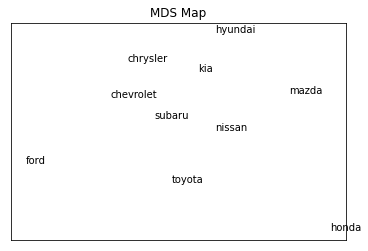

In [2]:
print("Top 10 Brands Frequency Table")
brand_sets = word_sets[word_sets['words'].isin(to_drop)]
print(brand_sets.sum(axis = 1).sort_values(ascending = False)[:10])

pd.set_option('display.expand_frame_repr', False)
print("\n\nLift Calculations Table")
print(pd.DataFrame(lift_square_matrix))

#Build MDS map from lift values
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import linear_kernel as cosine_distances
from sklearn.metrics.pairwise import manhattan_distances as manhattan_distances 
binary_variables = list(top_brand_sets.columns)
brand_matrix = top_brand_sets.to_numpy().transpose()
distance_matrix = manhattan_distances(brand_matrix)
mds_method = manifold.MDS(n_components=2, random_state = 9999, dissimilarity = 'precomputed')
mds_fit = mds_method.fit(distance_matrix)
mds_coordinates = mds_method.fit_transform(distance_matrix) 
plt.figure()
plt.scatter(mds_coordinates[:,0], mds_coordinates[:,1], facecolors = 'none', edgecolor = 'none')
plt.xticks([])
plt.yticks([])
plt.title("MDS Map")
labels = binary_variables 
for labels, x, y in zip(labels, mds_coordinates[:,0],mds_coordinates[:,1]):
    plt.annotate(labels, (x,y), xycoords = 'data')
plt.show()

**Task B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)?**

1. Ford doesn't show strong similarity with any of the other brands except a slight association with Chevrolet.

2. Honda doesn't show strong similarity with any of the other brands except a slight association with Toyota.

3. Hyundai and Kia are the two most similar brands, and Kia is the most frequently associated brand with other brands.

**expand on this section**


**Task C: What are 5 most frequently mentioned attributes of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.**





In [ ]:
##insert Task C code here

**Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive).**

**insert Task D analysis here**

**Task E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


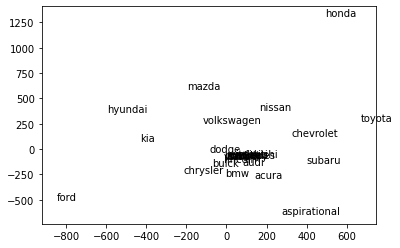

In [3]:
import pandas as pd 
import nltk
import numpy as np
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from collections import defaultdict
import re
from nltk.corpus import stopwords
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
from google.colab import files
import io

file = pd.read_csv('comments.csv')
file['comments'] = file['comments'].astype(str)
file["comments"] = file["comments"].str.lower()

brandconverter = pd.read_csv("car models and brands.csv",header = None)
brandconverter.columns = ['brand','model']
s = brandconverter.set_index('model')['brand']
s.index = r'\b' + s.index + r'\b' # Takes care of word boundary condition
file['comments'] = file['comments'].replace(s, regex=True)

aspirationalwords = pd.read_csv(io.BytesIO(uploaded['aspirational words.csv']), header=None)
aspirationalwords.columns = ['aspirational', 'words']
t = aspirationalwords.set_index('words')['aspirational']
t.index = r'\b' + t.index + r'\b' # Takes care of word boundary condition
file['comments'] = file['comments'].replace(t, regex=True)

nltk.download('stopwords')
nltk.download('punkt')
stops =set(stopwords.words("english"))
def identify_tokens(row):
    tokens = nltk.word_tokenize(row)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

file['words'] = file['comments'].apply(identify_tokens)

def remove_stops(row):
    row
    non_stop = [w for w in row if not w in stops]
    return (non_stop)

file['words'] = file['words'].apply(remove_stops)

def rejoin_words(row):
    row
    joined_words = ( " ".join(row))
    return joined_words

file['processed'] = file['words'].apply(rejoin_words)
cv=CountVectorizer()
word_count_vector = cv.fit_transform(file['processed'])
word_count = pd.DataFrame(word_count_vector.T.todense(), index=cv.get_feature_names()) 
word_freq_matrix = word_count.T

counter = Counter(chain.from_iterable(map(str.split, file['processed'].tolist()))) 
view = word_count_vector.data
series = pd.Series(counter).sort_values(ascending=False)
term_freq = series.reset_index()
term_freq.columns = ['words','freq']
to_drop = list(brandconverter['brand'].unique())
to_drop.remove('problem')
to_drop.remove('seat')
to_drop.remove('car')
to_drop.remove('sedan')
to_drop.append('aspirational')

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
word_sets = word_count.applymap(encode_units)
word_sets['words'] = word_sets.index.values
brand_sets = word_sets[word_sets['words'].isin(to_drop)]

brand_sets = brand_sets.drop(columns = 'words')
brand_sets = brand_sets.T

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
frequent_itemsets = apriori(brand_sets, min_support=0.001, use_colnames=True )

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
lift_table = rules[['antecedents','consequents', 'lift']]
lift_table['length_antecedents'] = lift_table['antecedents'].apply(lambda x: len(x))
lift_table['length_consequents'] = lift_table['consequents'].apply(lambda x: len(x))

lift_table = lift_table[lift_table['length_antecedents'] == 1]
lift_table = lift_table[lift_table['length_consequents'] == 1]
lift_table = lift_table.drop(columns =['length_consequents','length_antecedents'] )

lift_table["antecedents"] = lift_table["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
lift_table["consequents"] = lift_table["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

lift_square_matrix = lift_table.pivot(index='antecedents', columns='consequents', values='lift')
lift_square_matrix = lift_square_matrix.fillna(0)
m,n = lift_square_matrix.shape
lift_square_matrix[:] = np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,lift_square_matrix)
lift_square_matrix = lift_square_matrix.fillna('')
lift_square_matrix.columns.name = None
lift_square_matrix.index.name = None

from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import linear_kernel as cosine_distances
from sklearn.metrics.pairwise import manhattan_distances as manhattan_distances 
binary_variables = list(brand_sets.columns)
brand_matrix = brand_sets.to_numpy().transpose()
distance_matrix = manhattan_distances(brand_matrix)
mds_method = manifold.MDS(n_components=2, random_state = 9999, dissimilarity = 'precomputed')
mds_fit = mds_method.fit(distance_matrix)
mds_coordinates = mds_method.fit_transform(distance_matrix) 
plt.figure()
plt.scatter(mds_coordinates[:,0], mds_coordinates[:,1], facecolors = 'none', edgecolor = 'none')
labels = binary_variables 
for labels, x, y in zip(labels, mds_coordinates[:,0],mds_coordinates[:,1]):
    plt.annotate(labels, (x,y), xycoords = 'data')

plt.show()


**First, how we measured aspirational.**

Add details here and print the aspirational table

In [5]:
pd.set_option('display.expand_frame_repr', False)
print("\n\nLift Calculations Table")
print(pd.DataFrame(lift_square_matrix)[:2])



Lift Calculations Table
             acura aspirational     audi      bmw    buick cadillac chevrolet chrysler    dodge     ford    honda hyundai infiniti      kia lincoln    mazda mitsubishi   nissan   subaru   toyota volkswagen volvo
acura                    1.4055  3.23148  3.72162  1.86128  7.47456   1.15211  1.21638  1.73811        0  2.01417       0  6.61211   1.3487  4.6716  1.05528          0  1.02128  1.53874  1.24412    1.13102     0
aspirational                     2.15664  2.18512  1.71101        0   1.66139  1.57438  1.59778  1.24821  1.33632  1.1332  2.67443  1.61837       0   1.6168          0  1.13597  1.56669  1.34953    1.15456     0


**Most aspirational brand is Inifiniti**

**Advice/insights based on analysis for brand, product, and advertising managers.**